## 유사도를 이용한 추천 시스템 구현하기

- Kaggle에서 사용되었던 영화 데이터셋으로 영화 추천 시스템 구현하기
- 최종목표 : <b>좋아하는 영화를 입력하면, 해당 영화의 줄거리와 유사한 영화를 추천하는 시스템</b>
- TF-IDF와 코사인 유사도만으로 영화의 줄거리에 기반한 영화 추천 시스템 만들기
- 다운로드 링크 : [https://www.kaggle.com/rounakbanik/the-movies-dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset)
- 위 링크에서 movies_metadata.csv 파일 다운로드(45466 x 24 shape)

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

data = pd.read_csv('movies_metadata.csv', low_memory = False)
data.head(2)   # 2개의 샘플로 데이터 형식 확인

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


- 코사인 유사도에 사용할 데이터는 제목인 "title"과 줄거리인 "overview"
- <b>tf-idf를 구할 때 데이터에 Null 값이 있으면 에러가 발생하므로 확인 필요!</b>

In [2]:
data = data.head(20000)
data['overview'].isnull().sum()

135

In [3]:
# overview에서 Null 값을 가진 경우에는 빈칸으로 Null 값 제거
data['overview'] = data['overview'].fillna('')

# tf-idf 수행
tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(data['overview'])
print(tfidf_matrix.shape)

(20000, 47487)


- overview 열에 대해 tf-idf를 수행한 결과로, 20,000개의 영화를 표현하기 위해 총 47,487개의 단어가 사용된 것을 확인
- linear_kernel : 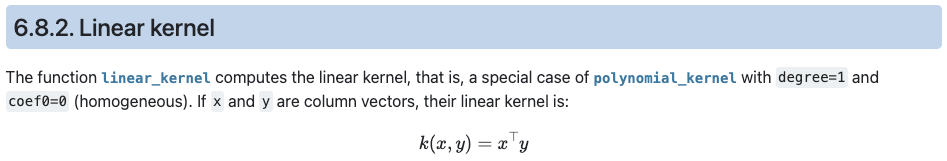

In [4]:
# 코사인 유사도를 사용하여 문서의 유사도 구하기
# 영화의 title과 index를 가진 테이블 만들기(용도 : 영화의 타이틀을 입력하면 index를 return하도록)

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)            # 코사인 유사도 계산
indices = pd.Series(data.index, index = data['title']).drop_duplicates()
print(indices.head())

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


In [6]:
indices.shape

(20000,)

In [7]:
idx = indices['Father of the Bride Part II']
print(idx)

4


In [9]:
cosine_sim.shape

(20000, 20000)

In [10]:
# 코사인 유사도를 이용하여 선택한 영화와 가장 overview가 유사한 10개의 영화를 찾는 함수
def get_recommendations(title, cosine_sim = cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))                          # 모든 영화에 대해 해당 영화와의 유사도 가져오기
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)  # 유사도 높은 순으로 내림차순 정렬
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    return data['title'].iloc[movie_indices]          # 가장 유사한 10개의 영화 제목 리턴

In [11]:
# 영화 '다크 나이트 라이즈'와 overview가 유사한 영화 찾기
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object